<a href="https://colab.research.google.com/github/ZibronJazzquez/BandStructure/blob/master/Revised_X_ray_Diffraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries

##Data Import

In [233]:
import pandas as pd
import os
import glob
import numpy as np
import math
from numpy.linalg import norm
import scipy
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from scipy.integrate import quad, simps
from scipy.special import spherical_jn as jn
import warnings

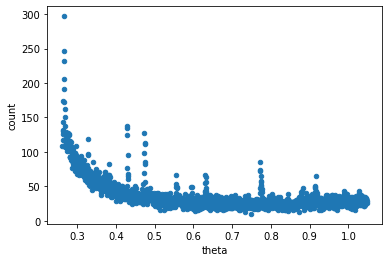

In [4]:
df_dict = {}
for sample in ['Al','CsCl','LiF','KCl','W']:
  url = "https://raw.githubusercontent.com/ZibronJazzquez/XRD-Data/main/"+sample+".csv"
  df = pd.read_csv(url)
  df = df.rename(columns ={'2Theta':'theta','Intensity (counts)':'count'})
  df['theta'] = np.deg2rad(df['theta']/2) 
  df['name'] = sample
  df_dict[sample] = df
data_LiF = df_dict['LiF']
data_KCl = df_dict['KCl']
data_W = df_dict['W']
data_Al = df_dict['Al']
data_CsCl = df_dict['CsCl']

theta_Error = 0.0005
data_CsCl.plot(x = 'theta',y ='count',kind = 'scatter')

##Mass/Density Data and Functions

$V_c ≈ \frac{ℳ}{\rho}$

$\implies a \approx \sqrt[3]{\frac{\alphaℳ}{\rho}}   $

where $ℳ$ is the molecular weight, $\rho$ is the macroscopic density, and $a$ is the lattice constant. \alpha is a packing parameter that varies for different symmetries. The minimum is 1 for SC and the max is 4 for FCC, so that's what we pass for the ends on the range.

In [5]:
#Useful constants
Na = 6.0221408*1e23
scale = 1e24/Na
ang=1e-10
alpha_mean = 1.5418*ang #X-ray wavelength in meters
alpha1, alpha2 = 1.540562*ang, 1.544390*ang
#################
m_Al = 26.981539*scale ;rho_Al = 2.7#g/cm³
m_LiF = 25.939*scale   ;rho_LiF = 2.64#g/cm³
m_KCl = 74.5513*scale  ;rho_KCl = 1.98#g/cm³
m_CsCl = 168.36*scale  ;rho_CsCl = 3.99#g/cm³
m_W = 183.84*scale;rho_W = 19.3 #g/cm3
mass_dict = {'Al':[m_Al,rho_Al,m_Al/rho_Al],'LiF':[m_LiF,rho_LiF,m_LiF/rho_LiF],'CsCl':[m_CsCl,rho_CsCl,m_CsCl/rho_CsCl],'W':[m_W,rho_W,m_W/rho_W],'KCl':[m_KCl,rho_KCl,m_KCl/rho_KCl]}
#Gives a range of potential values of the lattice constant
#based on a sample's density
def lattice_constant_range(sample_name,sym,N):
  global mass_dict
  inv_pf = 1 #inverse packing fracking (1, 2, or 4)
  if sym == 'SC':
    inv_pf = 1
  if sym == 'BCC':
    inv_pf = 2
  if sym == 'FCC':
    inv_pf = 4
  v_c = mass_dict[sample_name][2]
  return np.linspace(ang*((inv_pf-.8)*v_c)**(1/3),ang*((inv_pf+.8)*v_c)**(1/3),N)

##Miller Indices

Here we want to be able to procedurally generate a table of Miller indices, as well as check to see if they correspond to peaks at different symmetries. An example would look something like:
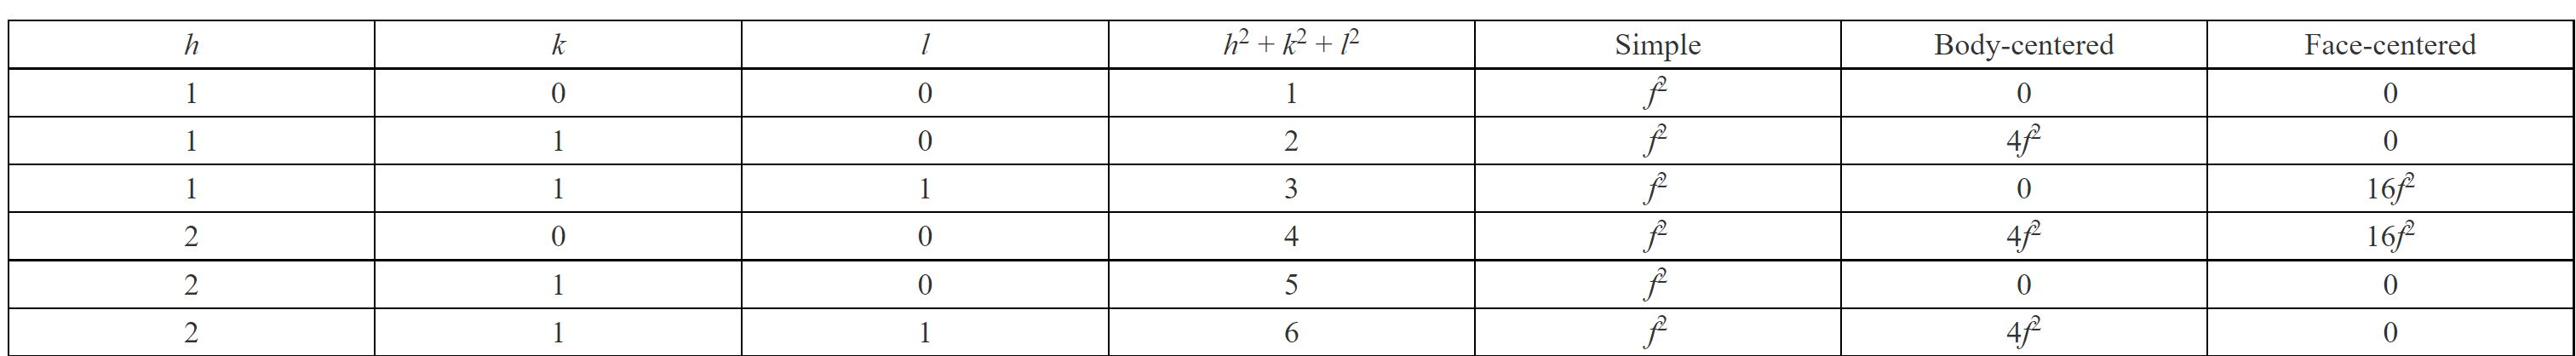

##Miller Generators

In [6]:
from math import gcd
#Procedurally generate miller indices 

def isMiller(indices):
  h,k,l = indices
  allNorm = gcd(h,k) == gcd(k,l)
  return allNorm
def isBCCMiller(indices):
  h,k,l = indices
  return 4*int((h+k+l)%2 == 0) #sum must have same parity
def isSCMiller(indices):
  h,k,l = indices
  return 4            #no restrictions
def isFCCMiller(indices):
  h,k,l = indices
  return 16*int(h%2 == k%2 == l%2)#must be same parity
def millerTable(n):
  miller_table = [];
  for h in range(n):
    for k in range(n):
      for l in range(n):
        m_v = [h,k,l] #"miller vector"
        if isMiller(m_v) and m_v!=[0,0,0]:
          m_v.sort(reverse = True)
          if m_v not in miller_table:
            miller_table.append([tuple(m_v),np.sqrt(np.inner(m_v,m_v)),isBCCMiller(m_v),isFCCMiller(m_v),isSCMiller(m_v)])
  output = pd.DataFrame(data = miller_table, columns = ['indices',"norm","BCC","FCC","SC"])
  output.sort_values('norm', inplace = True)
  output.drop_duplicates(inplace = True)
  return output

##Symmetries
>list of symmetries we will use. n = 10 is large enough to give us values that will at the very least span the theta range

In [105]:
#Generate "symmetries"  
mt = millerTable(10)
bcc = mt[mt.BCC == 4] #contains all Miller Indices with BCC peak at 4f^2
fcc = mt[mt.FCC == 16]#likewise
sc = mt[mt.SC == 4]#ditto
symmetries = {"BCC":bcc,"FCC":fcc,"SC":sc}
print(mt)

       indices       norm  BCC  FCC  SC
0    (1, 0, 0)   1.000000    0    0   4
33   (1, 1, 0)   1.414214    4    0   4
34   (1, 1, 1)   1.732051    0   16   4
10   (2, 0, 0)   2.000000    4   16   4
2    (2, 1, 0)   2.236068    0    0   4
..         ...        ...  ...  ...  ..
473  (9, 9, 6)  14.071247    4    0   4
438  (9, 8, 8)  14.456832    0    0   4
481  (9, 9, 7)  14.525839    0   16   4
486  (9, 9, 8)  15.033296    4    0   4
488  (9, 9, 9)  15.588457    0   16   4

[191 rows x 5 columns]


Next, we want to be able to generate a *template* using a "Miller table". Basically, given an input λ (and of course this parameter could vary), and lattice constant *a*, we spit out the corresponding locations of the Bragg peaks with indices in the table.

$\theta = \arcsin\frac{λ\sqrt{h^2+k^2+l^2}}{2a}$

In [8]:
#takes in the miller indices of a crystal symmetry, 
#along with a lattice constant, and gives the corresponding 2theta locations
def template(mt,a,wavelength,maxTheta): 
  thetas_2 = [];peak_norms = [];peak_indices = []
  norms = mt.norm.values
  triples = mt.indices.values
  for i in range(len(norms)):
    peak_index = triples[i]
    millerNorm = norms[i]
    if wavelength*millerNorm/(2*a) <=np.sin(np.deg2rad(maxTheta/2)) and wavelength*millerNorm/(2*a)>=.2:
      peakTheta = 2*np.rad2deg(np.arcsin(wavelength*millerNorm/(2*a)))
      thetas_2.append(peakTheta)
      peak_norms.append(millerNorm)
      peak_indices.append(peak_index)
  return (thetas_2,peak_norms,peak_indices)


#Curve Fitting


## Finding Peaks

In [137]:
#Just some functions to make it easier to "zoom in" on  the peaks we found
#by eye
def almostIn(x,val_list):
  n = len(val_list)
  for i in range(n):
    if abs(val_list[i]-x)<.05:
      return i

def peak_zoom(df,w,peakTheta,display):
  if almostIn(peakTheta,df['theta']):
    i = almostIn(peakTheta,df['theta'])
    l,r = max(i-w,0),min(i+w,len(df['theta']))
    if display:
      plt.scatter(df['theta'].values[l:r],df['count'].values[l:r])
    return df['theta'].values[l:r],df['counts'].values[l:r]

In [138]:
#determines where the peaks are in signal by both
#smoothing the data and then checking each points neighbors for
#values with a certain "prominence" (in this case, "is a point above the std?")
def find_diff_peaks(df):
  wlen = 25
  sample = df.name.values[0]
  x,y = df['theta'],df['count']
  ysmooth = savgol_filter(y,wlen,5)
  maxMSE = mse(y,ysmooth)
  smooth_data = {'theta':x,'count':ysmooth}
  smooth_df = pd.DataFrame(data = smooth_data)
  #print(smooth_df)
  highest = max(ysmooth)
  noise = y.describe()['std']
  peaks,_= find_peaks(ysmooth, wlen= wlen,prominence=(.3*noise,highest))
  a = len(peaks)
  for peak in peaks:
    zoom = peak_zoom(smooth_df,wlen,peak,display = False)
    if zoom != None:
      try:
        l_popt,l_error,g_popt,g_error = cauchy_fits(zoom,False,sample)
        g_mse = mse(gaussian(zoom[0],*g_popt),zoom[1])
        l_mse = mse(lorentzian(zoom[0],*l_popt),zoom[1])
        gamma = l_popt[1]
        if gamma>0.05: #if the width exceeds the distance between pts
          indices = np.where(peaks==peak)
          peaks = np.delete(peaks, indices)
      except:
        indices = np.where(peaks==peak)
        peaks = np.delete(peaks, indices)
  b= len(peaks)
  #print(a-b)
  return (np.array(x[peaks]), ysmooth[peaks])  

In [139]:
def display_found_peaks(df):
  sample = df.name.values[0]
  #plt.figure(figsize=(12,6))
  #plt.title(sample)
  plt.scatter(find_diff_peaks(df)[0],find_diff_peaks(df)[1],label = "Found Peaks")
  #plt.scatter(df['theta'],df['count'],c = 'r',s = .8,alpha = .5,label ="Raw Data")
  #plt.xlabel("θ (rad)")
  #plt.ylabel("counts")
  #plt.legend()


##Cauchy

###Functions

In [115]:
def lorentzian(x,x0,gamma,I,b): #x0 = location of peak, gamma = HWHM, I = height of peak, b = background
  numerator = gamma/np.pi
  denominator = (x-x0)**2+gamma**2
  
  return b + I*numerator/denominator
def gaussian(x,x0,a,I,b):
  return I*np.exp(-.5*((x-x0)/a)**2)+b

###Fit Packages

In [114]:
def cauchy_fits(zoom,display,title):    
    #Guess Parameters #####################################
    x0_guess = (max(zoom[0])+min(zoom[0]))/2
    b_guess = min(zoom[0])
    I_guess = max(zoom[1])-b_guess
    a_guess = .4
    gamma_guess = 0.01
    #Fit Parameters #######################################
    try:
      l_popt, l_pcov = curve_fit(lorentzian,zoom[0],zoom[1],p0=(x0_guess,gamma_guess,I_guess,b_guess))
      g_popt, g_pcov = curve_fit(gaussian,zoom[0],zoom[1],p0 = (x0_guess,a_guess,I_guess,b_guess))
      g_error = np.sqrt(np.diag(g_pcov))
      l_error = np.sqrt(np.diag(l_pcov))
    except RuntimeWarning:
      return None

    if display:
      plt.scatter(zoom[0],zoom[1],s=1.8,c = 'b')
      x = np.linspace(zoom[0][0],zoom[0][-1],1000)
      gamma = l_popt[1]; sigma = g_popt[1]
      l_peak = l_popt[0]; g_peak = g_popt[0]
      gamma_str =  r"$\gamma$"+f" ={round(gamma,3)}"
      sigma_str = r"$\sigma$" +f" ={round(sigma,3)}"

      #Curve Plots
      plt.plot(x,lorentzian(x,*l_popt),c = 'g',ls='solid',label =gamma_str)
      plt.plot(x,gaussian(x,*g_popt),c = 'r',ls='solid', label = sigma_str)
      #Display Widths
      lor_width_x = np.linspace(l_peak-gamma,l_peak+gamma,100)
      plt.plot(lor_width_x,lorentzian(lor_width_x[0],l_popt[0],l_popt[1],l_popt[2],l_popt[3])*np.ones(100), c ='g',alpha = .5)
      g_width_x =  np.linspace(g_peak-sigma,g_peak+sigma,100)
      plt.plot(g_width_x,gaussian(g_peak-sigma,g_popt[0],g_popt[1],g_popt[2],g_popt[3])*np.ones(100), c ='r',alpha = .5)
    return l_popt,l_error,g_popt,g_error

##Fraunhofer

###Functions

In [118]:
def fraunhofer(theta,x0,I,d,b):
  k = 2*np.pi/alpha_mean
  N = 1 #We're assuming multi-layer diffraction
  A = d*k*(theta-x0)/2
  R = np.sin(A)/A
  L = np.sin(N*A)/np.sin(A)
  return I*((R*L))**2+b

###Fit Packages



In [181]:
from scipy.optimize.optimize import OptimizeWarning
def find_midpt(x_pts,y_pts):
  for i in range(1,len(x_pts)):
    L = simps(x_pts[:i],y_pts[:i])
    R = simps(x_pts[i:],y_pts[i:])
    if abs(L/R -1) <.01:
      return i  
def fit_fraunhofer(df):
  f_peaks,intensities = find_diff_peaks(df)
  warnings.filterwarnings("ignore")
  y = df['count'].values
  x = df['theta'].values
  i_max = np.where(y==max(y))[0][0]
  x_guess = x[i_max]
  b_guess =min(y)+df['theta'][-100:].describe()['std']
  I_guess = max(y)-b_guess
  M = [];params = [];D = []
  sample = df.name.values[0]
  N = 1000
  for d in lattice_constant_range(sample,sym,N):
    d_guess = d
    popt = [x_guess,I_guess,d_guess,b_guess] 
    p0 = [x_guess,I_guess,d_guess,b_guess]
    try:
      #bounds = ([min(x),min(y),3*ang,0],[max(x),max(y),7*ang,b_guess])
      popt, pcov = curve_fit(fraunhofer,f_peaks,intensities,p0 = p0)
    except (OptimizeWarning,RuntimeWarning,RuntimeError) as error:
      popt = [x_guess,I_guess,d_guess,b_guess]
    f_pts = fraunhofer(x,*popt)
    df = pd.DataFrame(data = f_pts)
    df = df.interpolate(method='linear', limit_direction='forward')
    #print(d_guess)
    MSE = mse(y,df[0])
    params.append(popt);M.append(MSE)
  for i in range(len(params)):
    d = params[i][2]
    D.append(d)
  #plt.title(sym)
  #plt.scatter(D,M,s=1,alpha = 0.8);plt.show()
  out_params = params[M.index(min(M))]
  #out_params[1]
  return out_params,min(M)

Displaying Fraunhofer fits for all samples at various symmetries
One thing to note is the fact that many of the Bragg Peaks are contained *within* the Fraunhofer envelope.

In [ ]:
for sample in df_dict:
  df = df_dict[sample]
  for sym in symmetries:
    p0,minError = fit_fraunhofer(df)
    print(sym,minError)
    x,y = df['theta'].values,df['count'].values
    plt.figure(figsize=(12,6))
    plt.title(f'{sample} ({sym})')
    plt.plot(x,fraunhofer(x,*p0))
    display_found_peaks(df)
    plt.scatter(x,y,c = 'r', s=1,alpha = .8);plt.show()

##Bragg Peaks

In [190]:
def bragg_peak(alpha,a,norm):
  return np.arcsin(.5*alpha*norm/a)
def bragg_peaks(df,sym,a):
  sym = symmetries[sym]
  b_peaks = []
  norms = sym.norm.values
  maxTheta = max(df['theta'].values)
  minTheta = min(df['theta'].values)
  i = -1
  norm = norms[0]
  alpha = alpha_mean
  while minTheta <= bragg_peak(alpha,a,norm) <maxTheta:
    i +=1
    norm = norms[i]
    b_peaks.append(bragg_peak(alpha,a,norm))
    if b_peaks[i]>=maxTheta:
      b_peaks.remove(b_peaks[i])
  return b_peaks
def a_guess(df,sym):
  sym = symmetries[sym]
  f_peaks,intensities = find_diff_peaks(df)
  i = 0#np.where(intensities==max(intensities))[0][0] #index of the highest peak
  #i = intensities.index(max(intensities)) 
  norms = sym.norm.values
  min_norm = min(norms)
  f = f_peaks[i]
  #fit to the first
  a1 = .5*(alpha1*min_norm)/np.sin(f)
  a2 = .5*(alpha2*min_norm)/np.sin(f)
  return a1,a2

In [238]:
def display_fraun_bragg(df,sym): #displays both the fraunhofer envelope and predicted bragg peaks
  x,y = df['theta'],df['count']
  popt,MSE = fit_fraunhofer(df)
  a = popt[2]
  plt.xlabel('θ (rad)');plt.ylabel('Counts')
  ag = a_guess(df,sym)[0]
  b_peaks = bragg_peaks(df,sym,ag)#we consider bragg from
  plt.scatter(b_peaks,fraunhofer(b_peaks,*popt),c = 'g',s = 25,marker = 'x',label = "Predicted Bragg Peaks")
  plt.vlines(b_peaks,ymin = np.zeros(len(b_peaks)),ymax = fraunhofer(b_peaks,*popt),lw = .6,colors = 'g')
  plt.scatter(x,y, c = 'r',s = 1,alpha = .8)
  display_found_peaks(df)
  plt.plot(x,fraunhofer(x,*popt),alpha = .83,c = 'b',lw = 1,label = 'Fraunhofer Envelope')


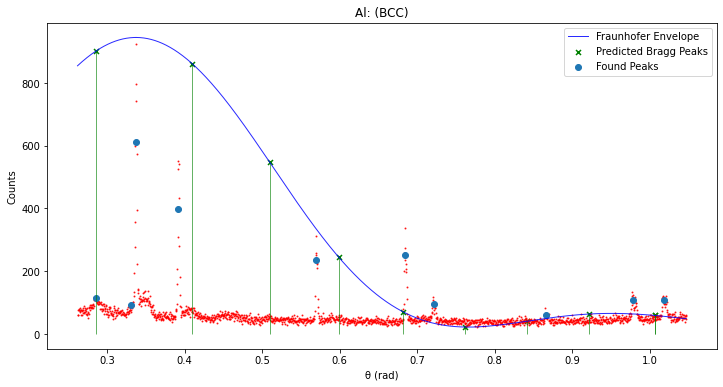

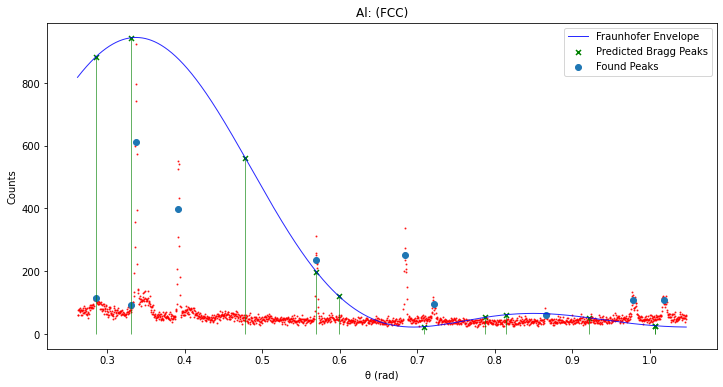

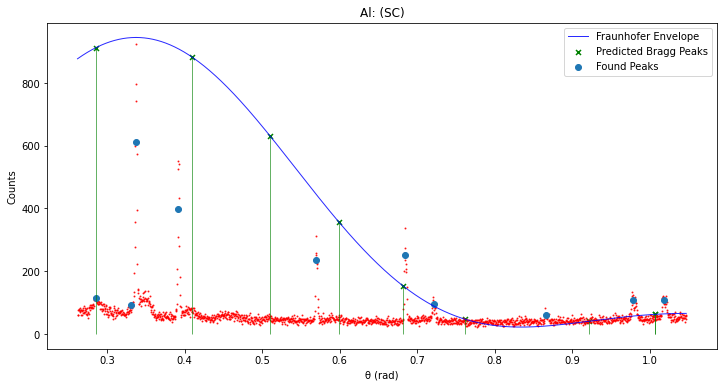

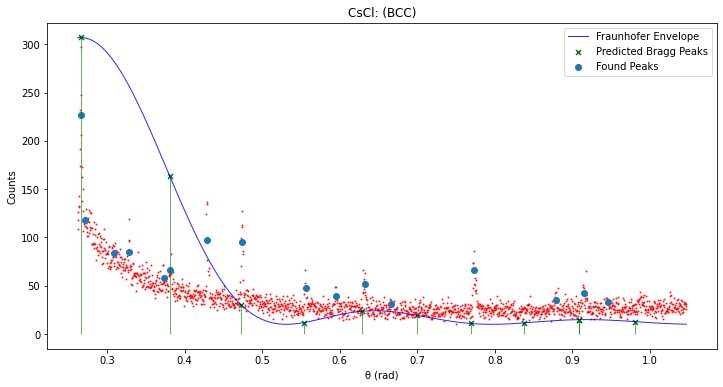

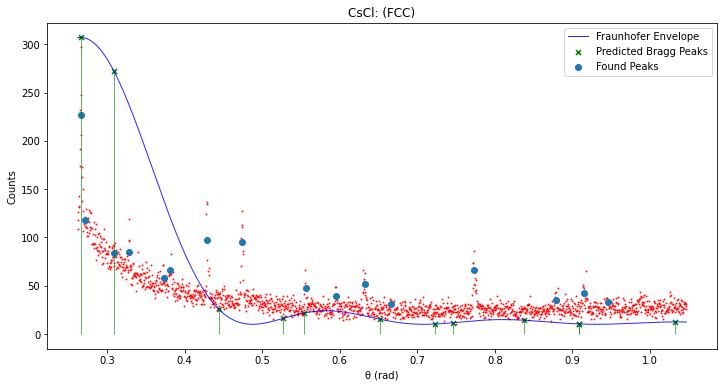

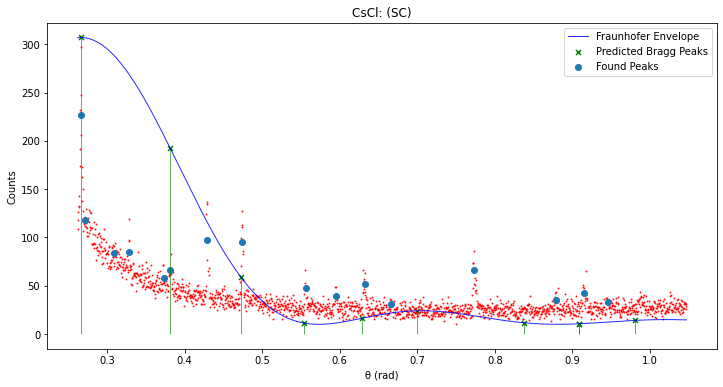

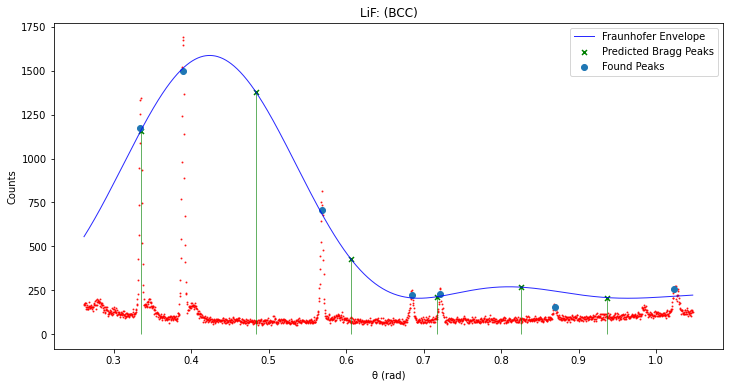

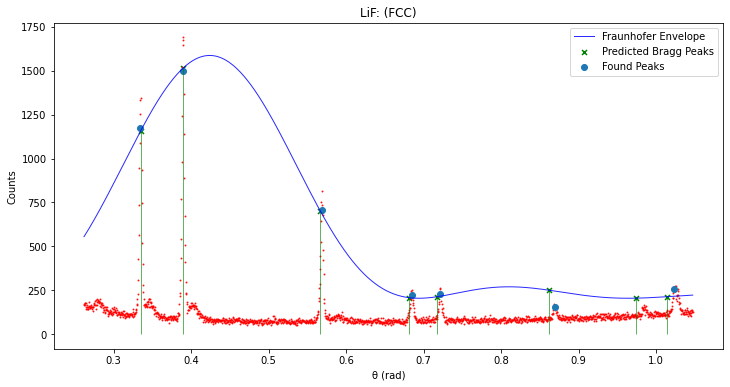

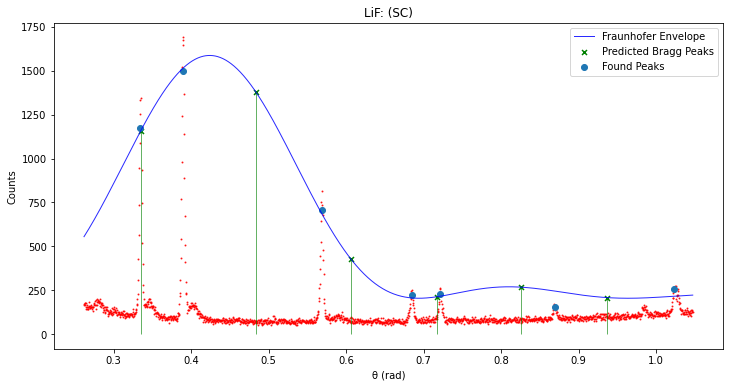

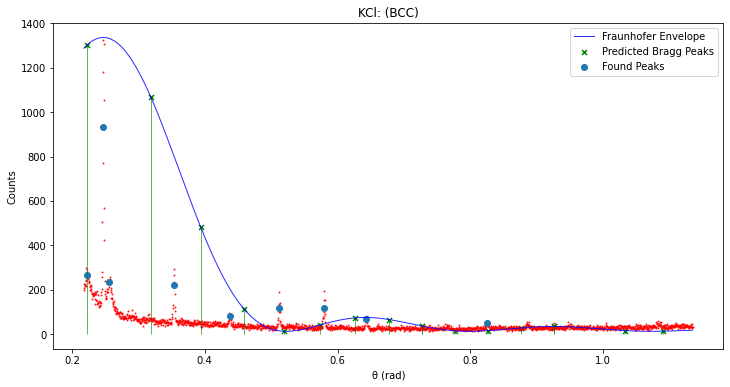

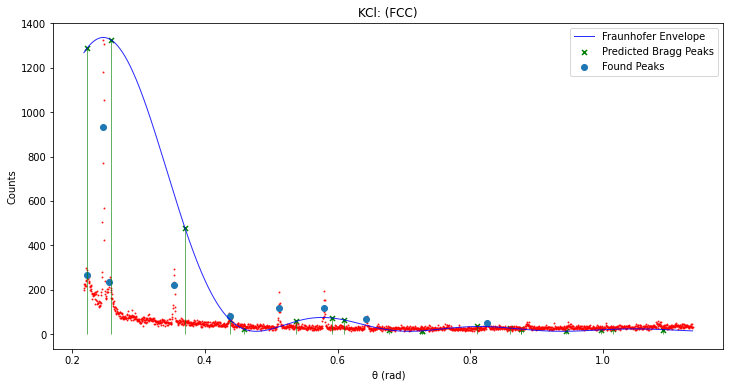

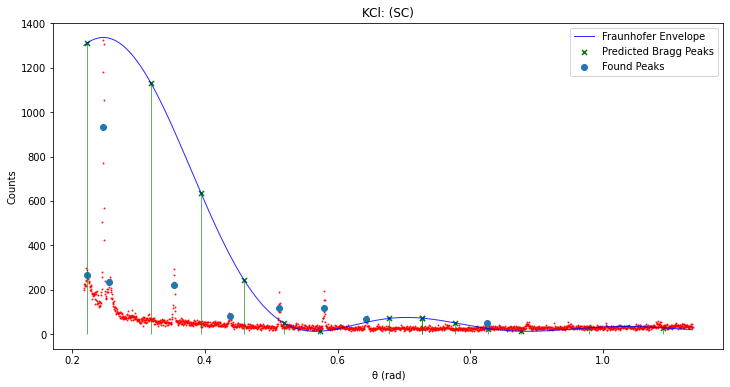

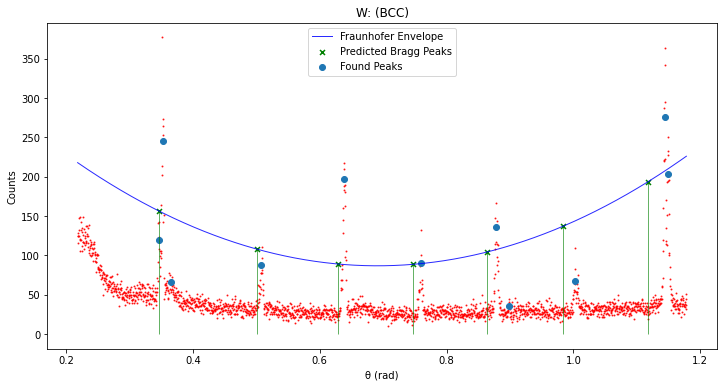

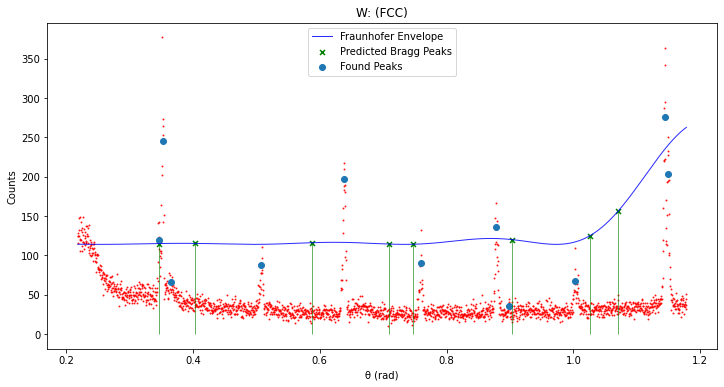

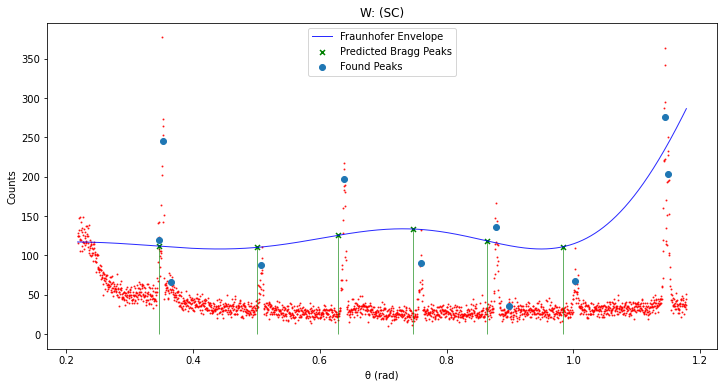

In [196]:
for sample in df_dict:
  df = df_dict[sample]
  for sym in symmetries:
    plt.figure(figsize=(12,6))
    plt.title(f'{sample}: ({sym})')
    display_fraun_bragg(df,sym)
    plt.legend()
    plt.show()
    

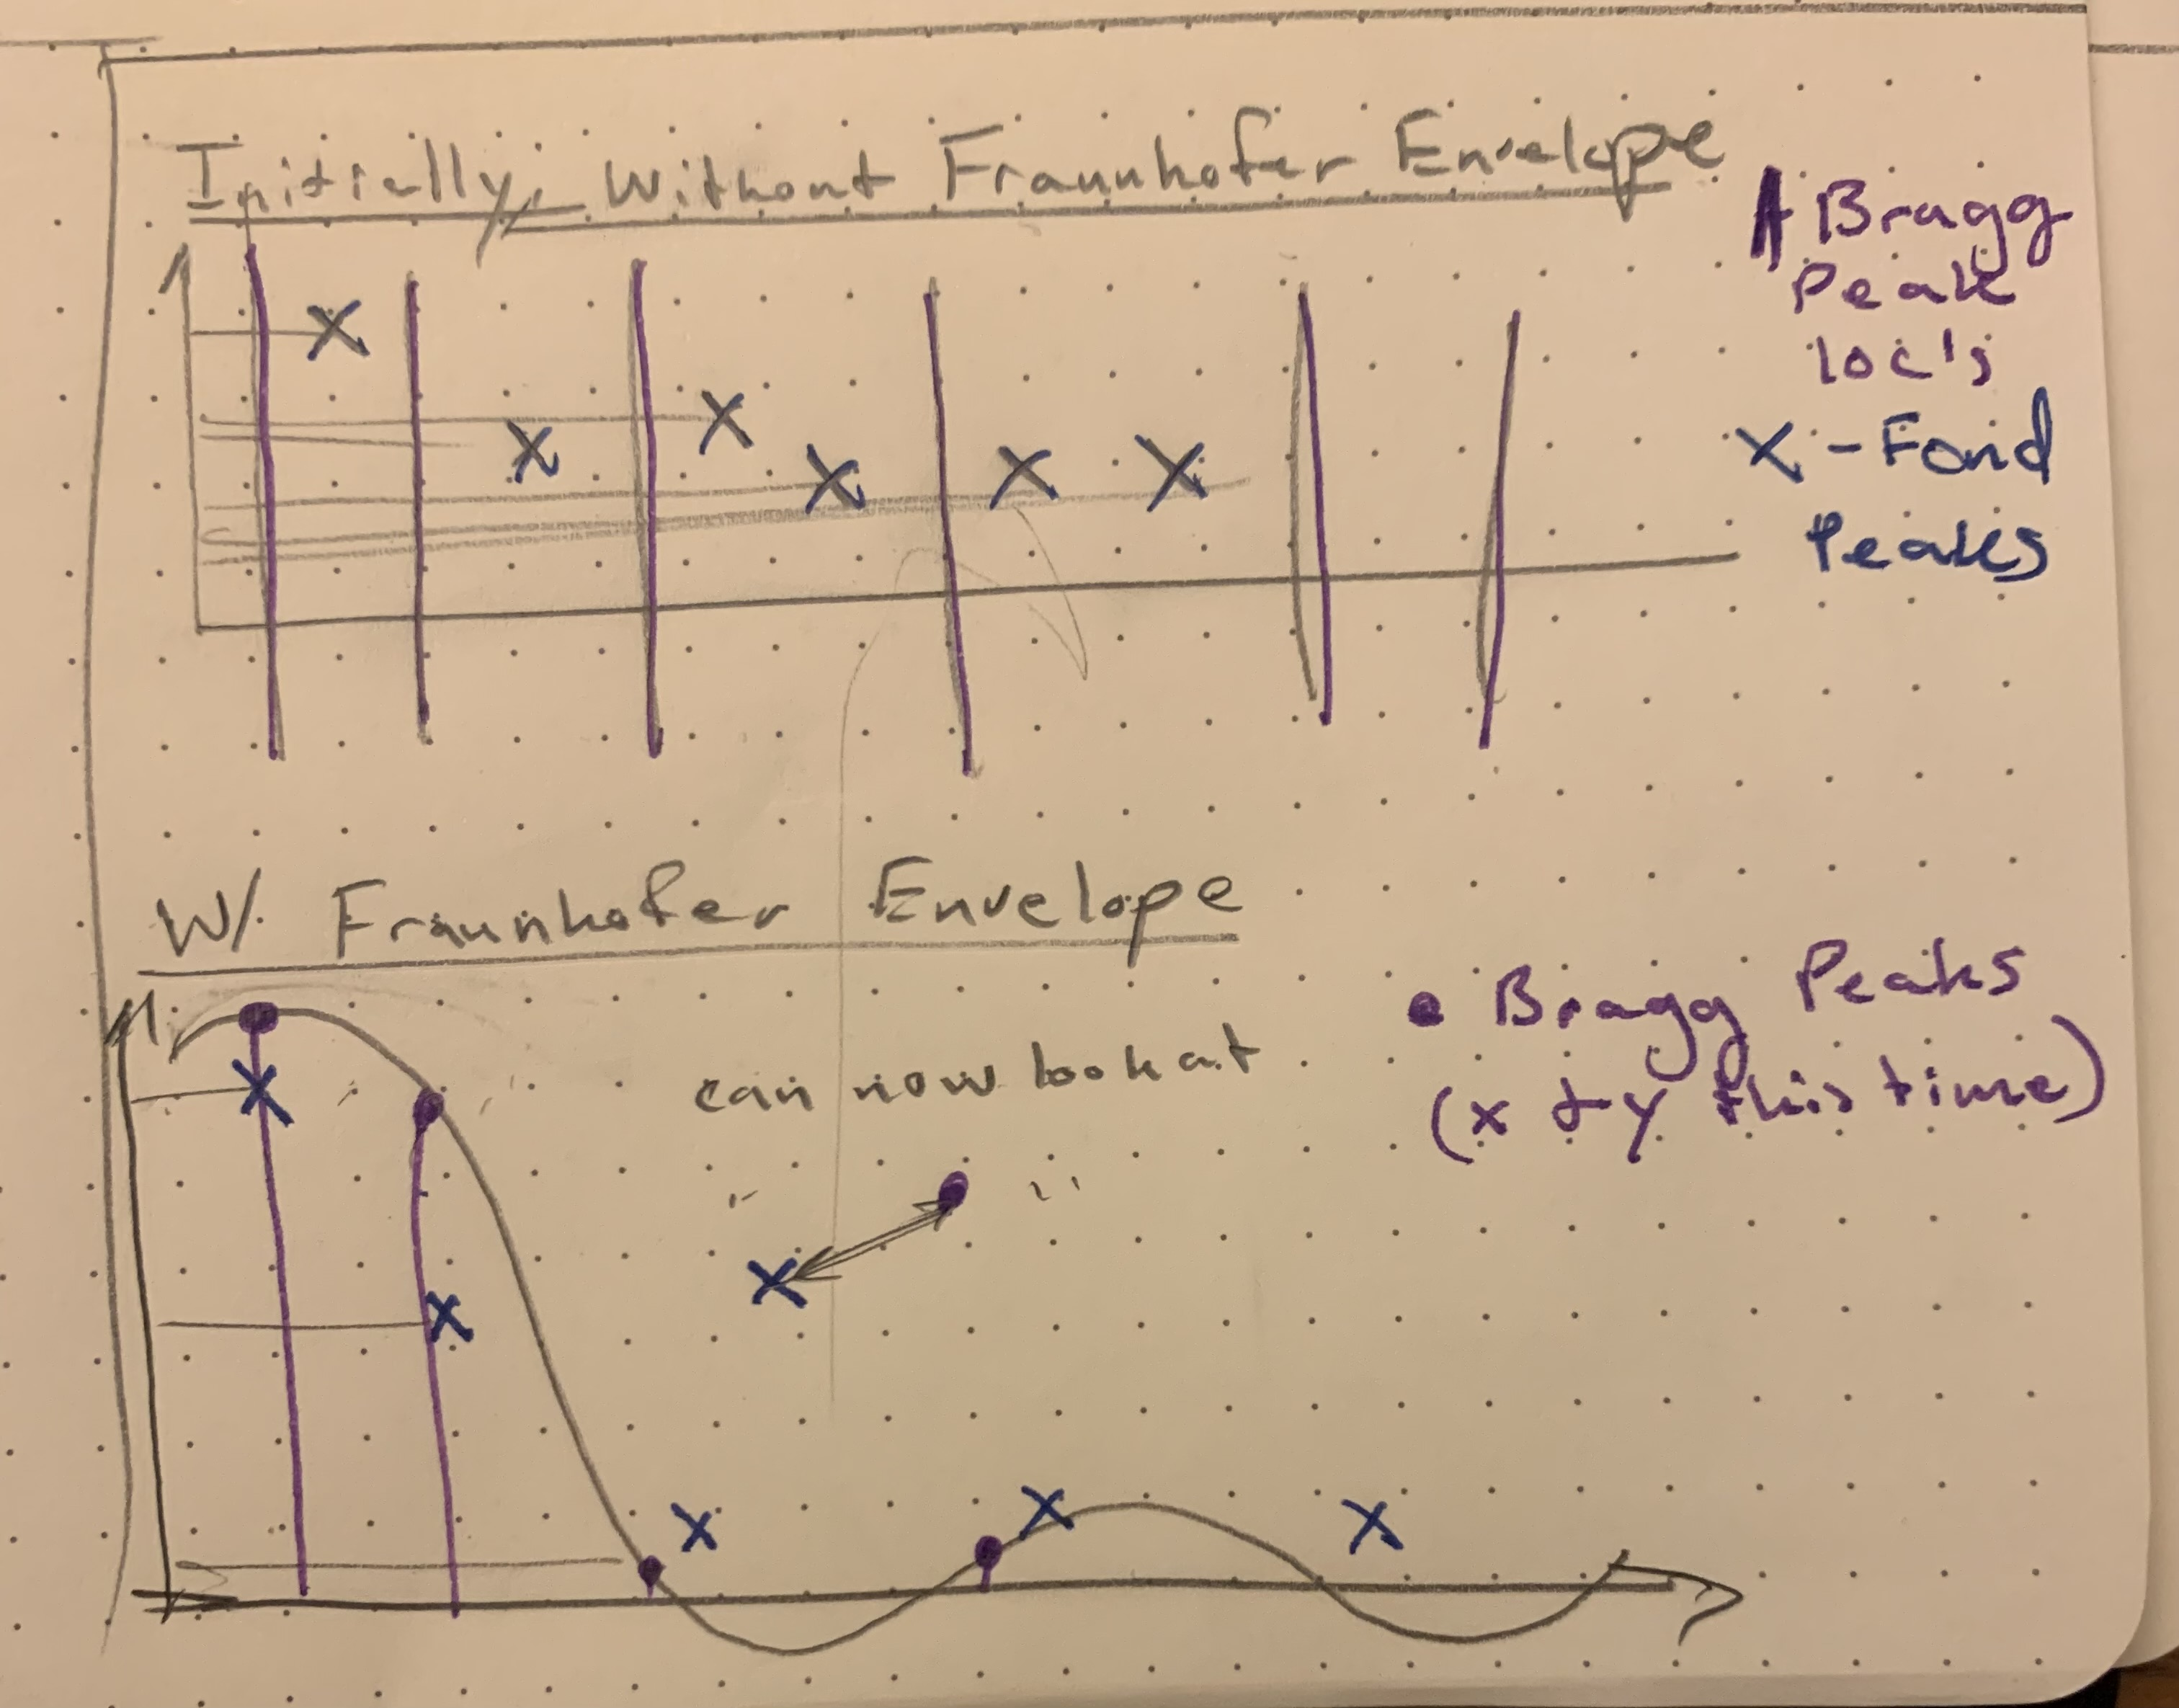

In [220]:
#Helper function to find euclidean distance between points
def dist(pt1,pt2):
  return np.sqrt((pt1[1]-pt2[1])**2+(pt1[0]-pt2[0])**2)

In [234]:
def lattice_constant(peaks,sym):
  warnings.filterwarnings("ignore")
  sym = symmetries[sym]
  aW = []; W = [] #weighed sum and sum of weights, respectively
  for i in range(len(peaks)):
    theta = peaks[i]
    norm = sym.norm.values[i]
    try:
      a_i = alpha_mean*norm/(2*np.sin(theta))
      w_i = (theta_Error*np.cos(theta)*alpha_mean*norm/(2*np.sin(theta))**2)**(-2)
    except (ZeroDivisionError) as error:
      w_i = 1E4

    aW.append(a_i*w_i);W.append(w_i)
  aW = np.array(aW);W = np.array(W)
  a = np.sum(aW)/np.sum(W)
  a_error = np.sqrt(1/np.sum(W))
  return a,a_error

#Classification!

In [235]:
def score_fit(df,sym):
  f_peaks,f_intensities = find_diff_peaks(df)
  popt,_ = fit_fraunhofer(df)
  ag = a_guess(df,sym)[0]
  b_peaks = bragg_peaks(df,sym,ag)
  b_intensities = fraunhofer(b_peaks,*popt)
  neighbors = []
  for i in range(len(b_peaks)):
    b_peak,b_intensity = b_peaks[i],b_intensities[i]
    dist_list = []
    for j in range(len(f_peaks)):
      f_peak,f_intensity = f_peaks[j],f_intensities[j] 
      d = dist([b_peak,b_intensity],[f_peak,f_intensity])
      dist_list.append(d)
    I = dist_list.index(min(dist_list))
    neighbor = f_peaks[I]
    neighbors.append(neighbor)
  a, a_error = lattice_constant(neighbors,sym)
  MSE = mse(b_peaks,neighbors)
 #score_list = np.array(score_list)
  return MSE,a,a_error

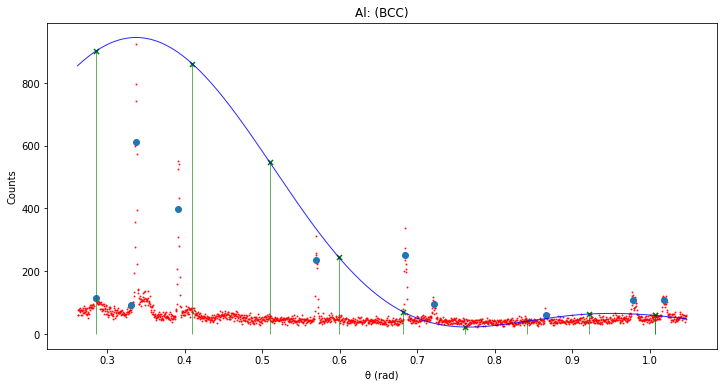

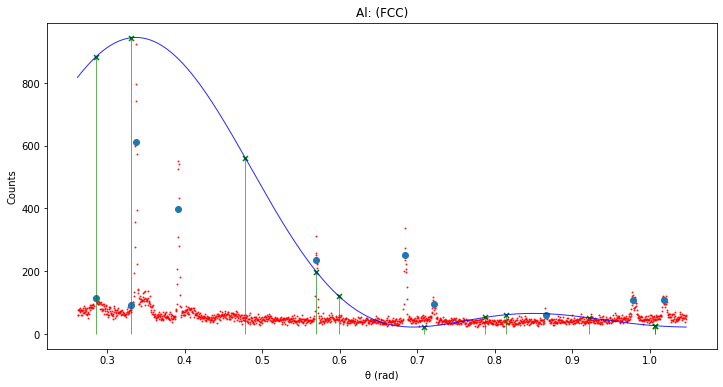

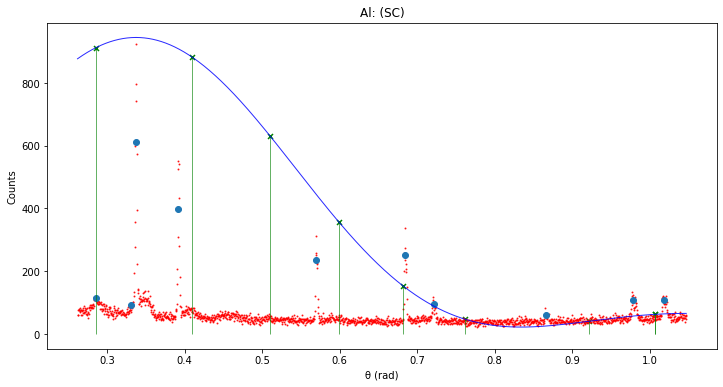

                  BCC           FCC            SC
MSE      1.334686e-02  1.790758e-02  3.231737e-02
a        3.746934e-10  4.670151e-10  2.844087e-10
a_error  3.084615e-14  3.877905e-14  2.886450e-14


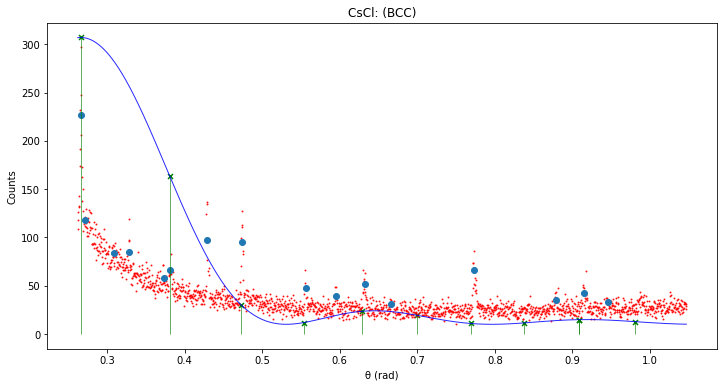

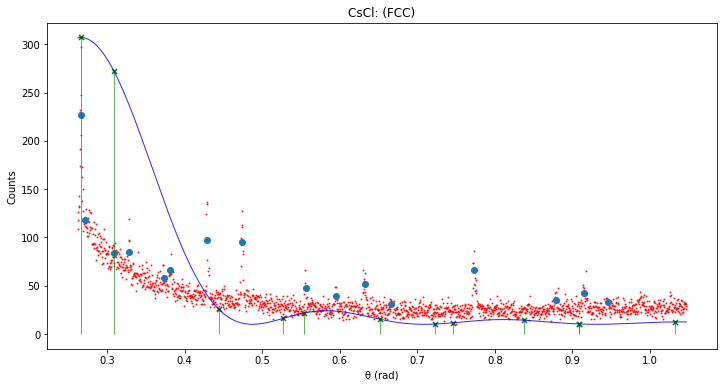

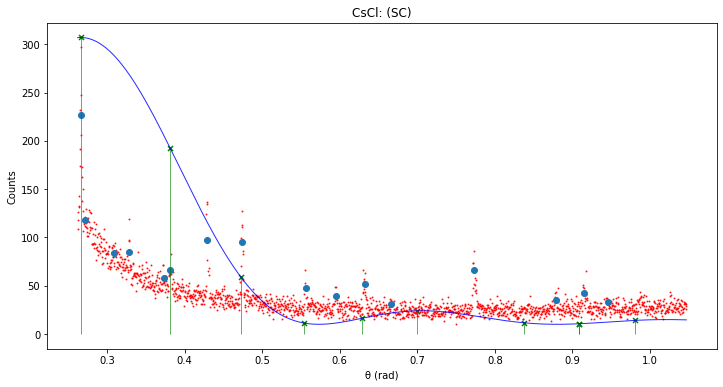

                  BCC           FCC            SC
MSE      2.913758e-02  3.108747e-02  2.833965e-02
a        4.186444e-10  4.929404e-10  3.172476e-10
a_error  4.465158e-14  5.013681e-14  3.733787e-14


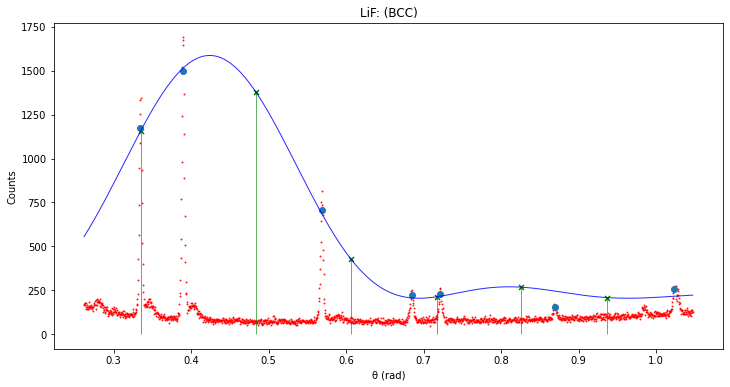

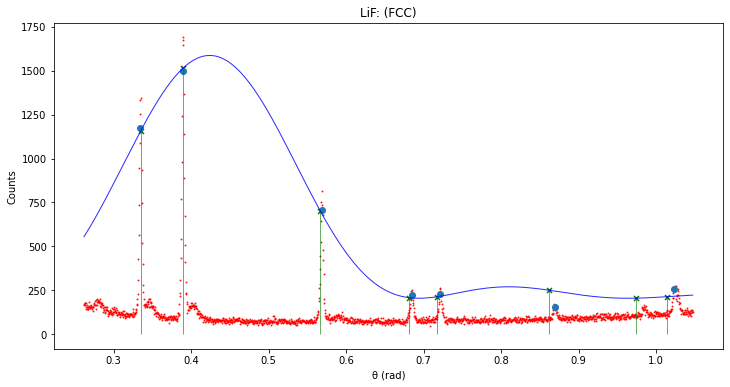

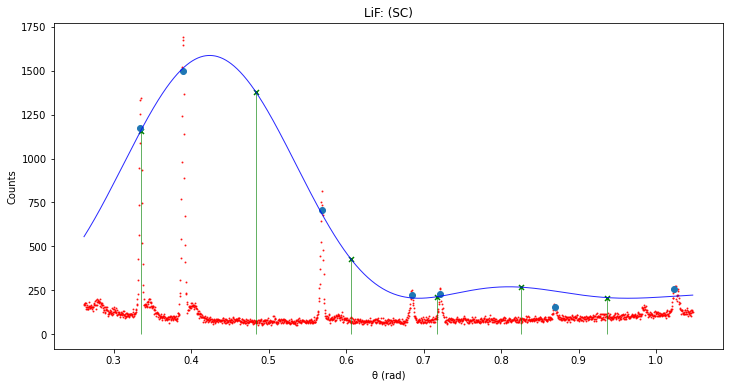

                  BCC           FCC            SC
MSE      4.781741e-02  2.741707e-02  4.781741e-02
a        2.600860e-10  3.987998e-10  1.839086e-10
a_error  2.504491e-14  4.091998e-14  1.770943e-14


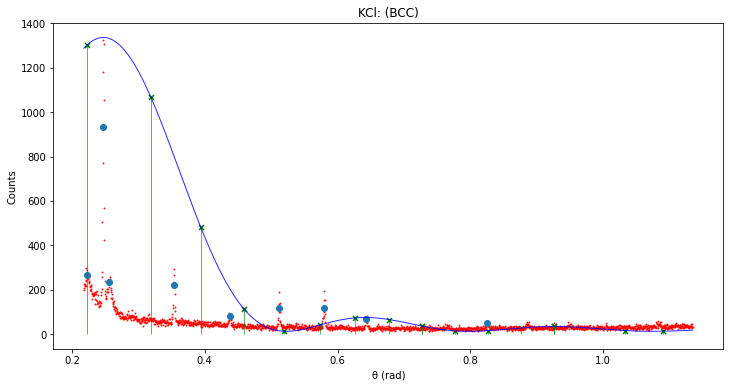

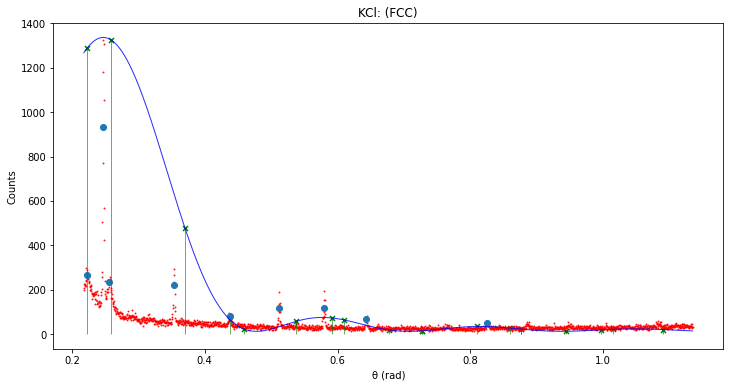

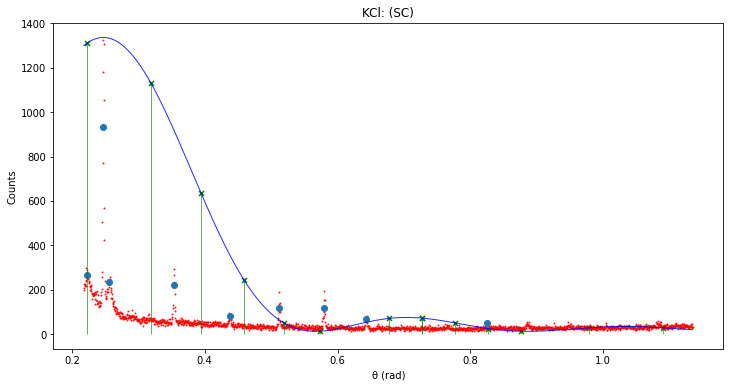

                  BCC           FCC            SC
MSE      2.150354e-02  2.531114e-02  2.428425e-02
a        4.537102e-10  5.363079e-10  3.188047e-10
a_error  3.013985e-14  3.314464e-14  2.556604e-14


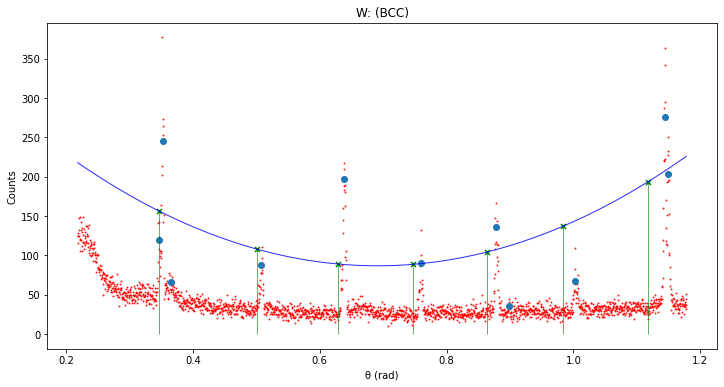

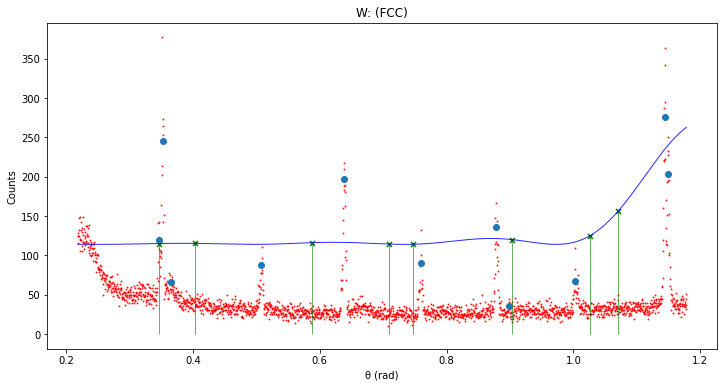

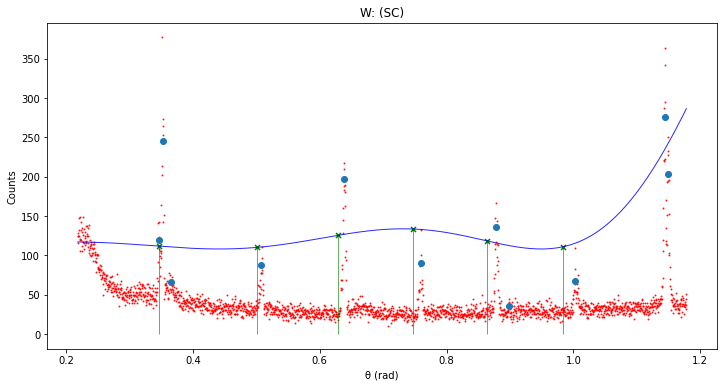

                  BCC           FCC            SC
MSE      9.034678e-02  1.451597e-01  1.323209e-01
a        2.069703e-10  4.791957e-10  2.167873e-10
a_error  2.403584e-14  7.999526e-14  3.867588e-14


In [237]:
sample_list = [];score_df_list = []
for sample in df_dict:
  sample_list.append(sample)
  df = df_dict[sample]
  score_dict = {}
  for sym in symmetries:
    #plt.title()
    plt.figure(figsize=(12,6))
    plt.title(f'{sample}: ({sym})')
    display_fraun_bragg(df,sym);plt.show()
    score_dict[sym] = score_fit(df,sym)
  score_df = pd.DataFrame(data = score_dict,index = ['MSE','a','a_error'])
  score_df_list.append([sample,score_df])
print(score_df_list)